In [1]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.model_selection
from evalutils import *
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rotationforest import *

In [28]:
oob_accs = []
test_accs = []
for seed in range(5):
    oob_accs_on_seed = []
    test_accs_on_seed = []
    for n_estimators in tqdm(range(20, 1021, 100)):
        rf = RandomForestClassifier(n_estimators = n_estimators, oob_score = True)
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=np.random.RandomState(seed))
        rf.fit(X_train, y_train)
        acc = sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
        oob_accs_on_seed.append(rf.oob_score_)
        test_accs_on_seed.append(acc)
    oob_accs.append(oob_accs_on_seed)
    test_accs.append(test_accs_on_seed)
        #sklearn.model_selection.cross_validate(rf, X, y)["test_score"]

  0%|          | 0/11 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


  0%|          | 0/11 [00:00<?, ?it/s]

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:546: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [29]:
oob_accs = np.array(oob_accs)
test_accs = np.array(test_accs)

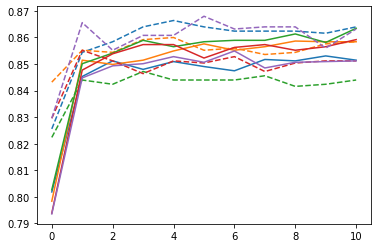

In [30]:
fig, ax = plt.subplots()
for i, (oob_curve, test_curve) in enumerate(zip(oob_accs, test_accs)):
    ax.plot(oob_curve, color=f"C{i}")
    ax.plot(test_curve, color=f"C{i}", linestyle="--")

# Models

In [ ]:
def get_ipl(sizes, scores):
    def ipl(beta):
        a, b, c = tuple(beta.astype(float))
        pl = lambda x: a + b * x **(-c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(ipl, np.array([1,1,1]), method="lm").x)
    return a, b, c, lambda x: a + b * x **(-c)

def get_vp(sizes, scores):
    def vp(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: np.exp(a + b/x + c * np.log(x))
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(vp, np.array([1,1,1]), method="lm").x)
    return a, b, c, lambda x: np.exp(a + b/x + c * np.log(x))


def get_mmf(sizes, scores):
    def mmf(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(mmf, np.array([1,1,1,1]), method="lm").x)
    return a, b, c, d, lambda x: (a * b + c * x ** d)/(b + x ** d)


def get_logpower(sizes, scores):
    def logpower(beta):
        a, b, c = tuple(beta.astype(float))
        fun = lambda x: a / (1 + (x / np.exp(b))**c)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c = tuple(sp.optimize.least_squares(logpower, np.array([1,1,1]), method="lm").x)
    return a, b, c, lambda x: a / (1 + (x / np.exp(b))**c)

In [ ]:
for openmlid, df_gaps_dataset in df_lcgaps.groupby("openmlid"):
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for j, (algo, df_algo) in enumerate(df_gaps_dataset.groupby("algo")):
        for est in ["ipl", "vp", "mmf", "log power"]:
            df_act = df_algo[["size", "gap " + est]].groupby("size").mean()
            ax[j].plot(df_act.index, df_act["gap " + est], label=est)
            
        df_act = df_algo[["size", "gap mmf", "gap log power"]].groupby("size").mean()
        ax[j].plot(df_act.index, 0.7 * df_act["gap mmf"] + 0.3 * df_act["gap log power"], label="mix")
        #print(df_algo)
        ax[j].axhline(0, linestyle="--", color="black", linewidth=1)
        ax[j].legend()
        ax[j].set_title(f"{algo} on {openmlid}")
        ax[j].set_ylim([-0.1, 0.1])
    plt.show()

In [ ]:
fig, ax = plt.subplots()
for i in range(len(gaps)):
    ax.plot(np.mean(gaps[i], axis=0))
ax.set_xlim([5,100])
ax.set_ylim([-0.1, 0.1])